In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import threading
import math
import pandas as pd
from scipy.optimize import minimize
import asyncio
import datetime
import hashlib
import os
import json
import gurobipy as gp
from gurobipy import GRB

In [2]:
def read_file(filename):
    with open(filename,"r") as f:
        df = pd.read_csv(f,header=None)
        return df.to_numpy()

In [3]:
D = read_file("Demand.csv")
values = np.array(D[:, 3])
points = np.array(D[:, 1:3])
x_range = [1, 9]
y_range = [0, 9]
n = len(values)
BUILD_COST = 600
CAPACITY = 1000
prohibited_rectangles = [((3.5, 5.2), (4.8, 6.2)), ((2.7, 3.3),  (3.0, 3.8)), ((3.2, 3.0),  (3.8, 3.4)), ((4.7, 4.2), (5.0, 4.5)), ((5.9, 2.9),  (6.2, 3.8))]
prohibited_circles = [((6.25, 7.45), 0.75)]

In [4]:
def le(x, y):
    epsilon = 1e-9
    return (x - y) >= epsilon
def is_in_prohibited_area(point, prohibited_rectangles, prohibited_circles):
    x, y = point
    for (x1, y1), (x2, y2) in prohibited_rectangles:
        if le(x, x1) and le(x2, x) and le(y, y1) and le(y2, y):
            return True
    for (xc, yc), radius in prohibited_circles:
        if le(radius, np.linalg.norm([x - xc, y - yc])):
            return True
    return False


In [5]:
def geometric_median_avoid_prohibited(X, weights, prohibited_rectangles, prohibited_circles):
    def objective(y):
        penalty = 0
        if is_in_prohibited_area(y, prohibited_rectangles, prohibited_circles):
            penalty = 1e6  # Large penalty for points inside prohibited areas
        distances = cdist(X, [y])
        weighted_sum = np.sum(distances * weights[:, np.newaxis])
        return weighted_sum + penalty
    
    y = np.mean(X, axis=0)
    result = minimize(objective, y, method='SLSQP')
    return result.x

In [6]:
def task(k):
    
    labels = labels = clusters.labels_
    geometric_medians = []
    for i in range(k):
        cluster_points = points[labels == i]
        if len(cluster_points) > 0:
            geometric_median_point = geometric_median_avoid_prohibited(cluster_points, np.ones(len(cluster_points)), prohibited_rectangles, prohibited_circles)
            geometric_medians.append(geometric_median_point)
        else:
            return -1
    return geometric_medians

In [7]:
k = 100
eps = 10**-4


centers_t = -1
while type(centers_t) is int:
    clusters = KMeans(k, max_iter=1000).fit(points)
    centers_t = task(k)
    centers = clusters.cluster_centers_

with open("Facility.txt", "w") as temp:
    for id, i in enumerate(centers_t):
        print(id + 1, *np.round(i, 3), CAPACITY, BUILD_COST, file=temp)

with open("TransCost.txt", "w") as temp:
    for j in centers_t:
        for i in D:
            print(np.round(np.linalg.norm(j - i[1:3]), 3), end=" ", file=temp)
        print("", file=temp)

In [8]:
f = pd.read_csv("Facility.txt", delimiter=" ", header=None).dropna(axis=1).to_numpy()
t = pd.read_csv("TransCost.txt", delimiter=" ", header=None).dropna(axis=1).to_numpy()
D = pd.read_csv("Demand.txt", delimiter="\t", header=None).to_numpy()

In [9]:
Env = gp.Env()
Env.setParam("OutputFlag", False)
model = gp.Model("2.6.2", Env)
x = model.addMVar(t.shape, vtype=GRB.CONTINUOUS, name="x")
c = model.addMVar((f.shape[0]), vtype=GRB.BINARY, name="c")
model.update()

model.addConstr(x.sum(axis=1) <= CAPACITY * c)
model.addConstr(x.sum(axis=0) >= D[:, -1])

model.setObjective((c * BUILD_COST).sum() + (x * t).sum(), sense=GRB.MINIMIZE)

model.optimize()

In [10]:
if model.status == GRB.Status.OPTIMAL:
    with open("2.6.out", "w") as temp:
        print(0, end=" ", file=temp)
        fi = 0
        for i in range(f.shape[0]):
            print(int(abs(np.round(c[i].X))), end=" ", file=temp)
            fi += c[i].X
        print("", file = temp)
        print(fi, file = temp)
        for i in range(f.shape[0]):
            if c[i].X:
                for j in range(D.shape[0]):
                    if x[i, j].X != 0:
                        print(f"{i + 1} {j + 1} {x[i, j].X}", file=temp)
        print(model.ObjVal, file=temp)

In [15]:
with open("2.6.out", "r") as temp:
    ch = [int(i) for i in temp.readline().split()]
    out_file = open("Nigga.txt", "w")

    for i in range(len(ch)):
        if ch[i]:
            print(f"{f[i, 1]} & {f[i, 2]} \\\\", file=out_file)

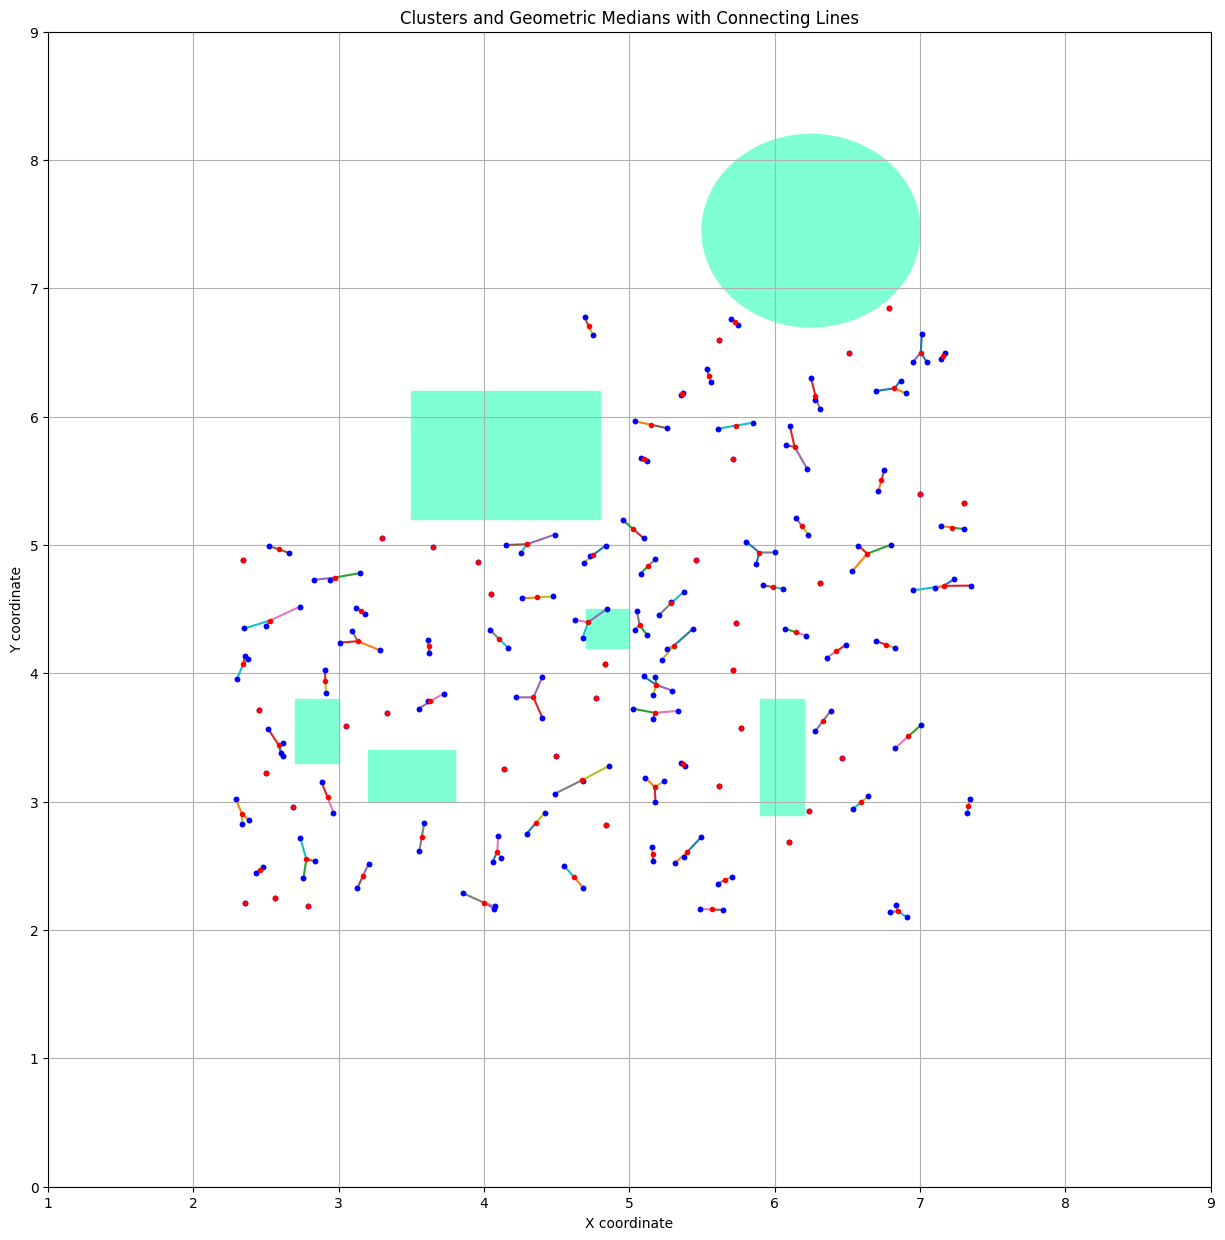

In [12]:
plt.figure(figsize=(15,15))
labels = clusters.labels_
plt.scatter(D[:, 1], D[:, 2], color="blue", marker=".", zorder=2)
plt.scatter(centers[:, 0], centers[:, 1], color="red", zorder=5, marker=".")
for id, i in enumerate(D):
    plt.plot([i[1], centers[labels[id]][0]], [i[2], centers[labels[id]][1]])

plt.scatter(D[:, 1], D[:, 2], color="blue", marker=".", zorder=2)
for (x1, y1), (x2, y2) in prohibited_rectangles:
        plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='Aquamarine', alpha=1)
    # Plot prohibited circles
for (xc, yc), radius in prohibited_circles:
    circle = plt.Circle((xc, yc), radius, color='Aquamarine', alpha=1)
    plt.gca().add_patch(circle)
plt.xlim(x_range)
plt.ylim(y_range)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Clusters and Geometric Medians with Connecting Lines')
plt.grid(True)
plt.show()
plt.close()

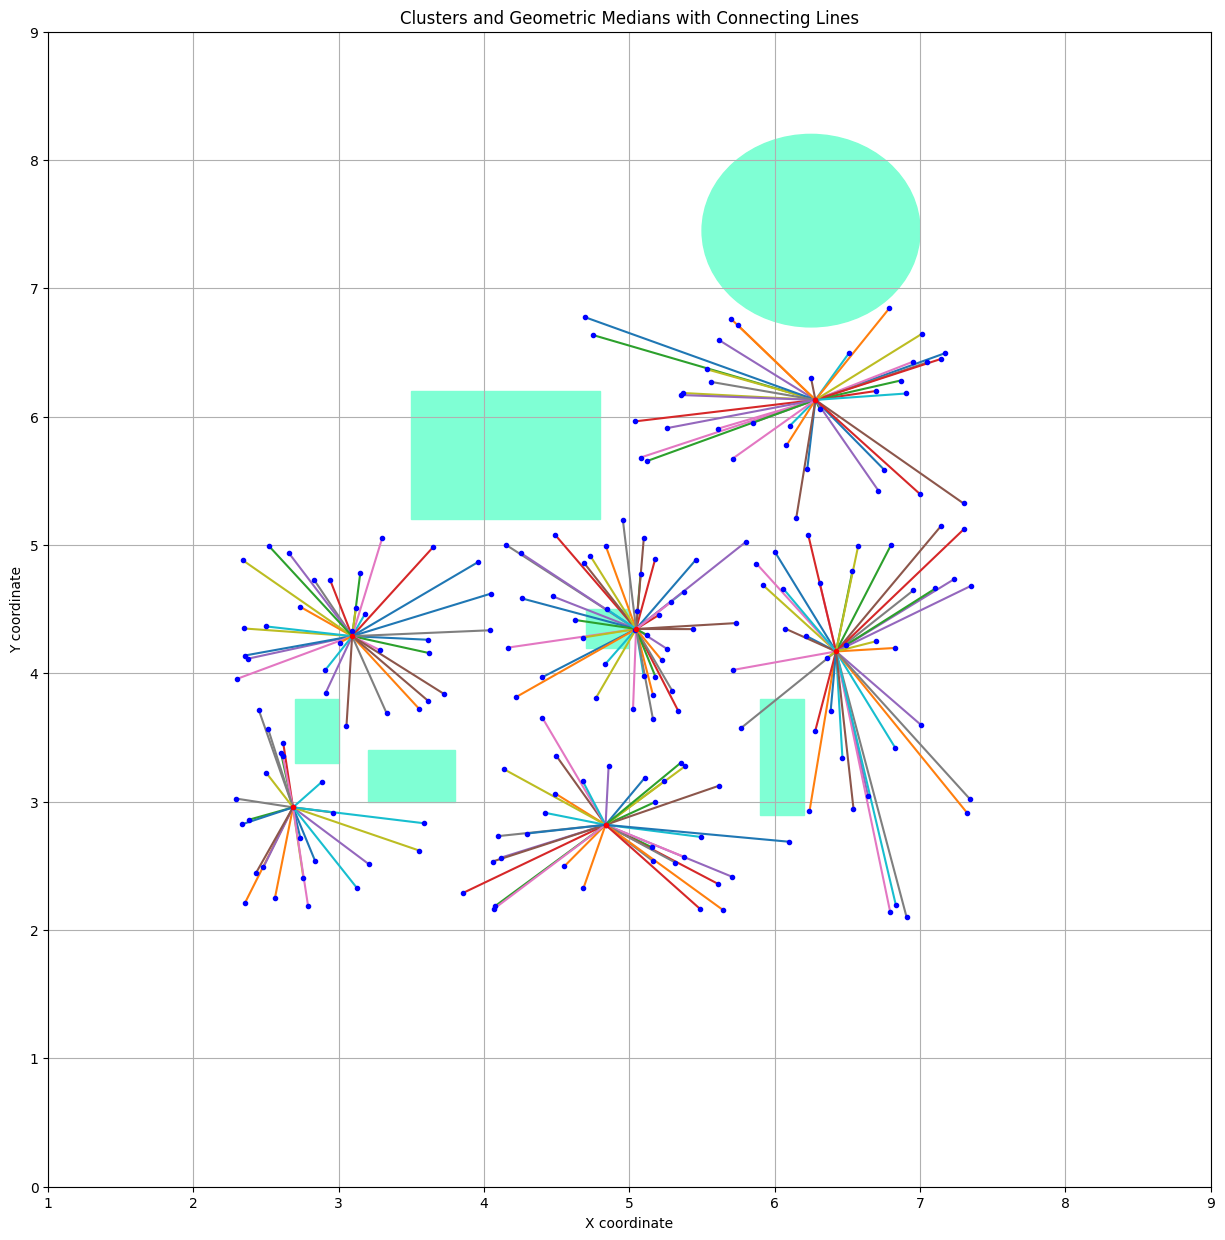

In [13]:
plt.figure(figsize=(15,15))
for i in range(c.shape[0]):
    if int(abs(np.round(c[i].X))):
        plt.scatter(f[i, 1], f[i, 2], color="red", zorder=5, marker=".")
    for j in range(D.shape[0]):
        if x[i, j].X != 0:
            plt.plot([f[i, 1], D[j, 1]], [f[i, 2], D[j, 2]])

plt.scatter(D[:, 1], D[:, 2], color="blue", marker=".", zorder=2)
for (x1, y1), (x2, y2) in prohibited_rectangles:
        plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='Aquamarine', alpha=1)
    # Plot prohibited circles
for (xc, yc), radius in prohibited_circles:
    circle = plt.Circle((xc, yc), radius, color='Aquamarine', alpha=1)
    plt.gca().add_patch(circle)
plt.xlim(x_range)
plt.ylim(y_range)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Clusters and Geometric Medians with Connecting Lines')
plt.grid(True)
plt.savefig("Nigga.png", dpi = 300)
plt.show()
plt.close()